In [99]:
#!pip install torch
#packages 
#Load packages :pytorch, sklearn etc.,
import numpy as np
import pandas as pd
import random
import os

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import copy
import time
import pickle

In [126]:
random.seed(4242)

## Getting Training and Validation Data

In [42]:
#reading in the .npz file to train the model 
def get_training_data(load=False, datafile ='test.npz'):
    
    if not load:
        # This grabs the training data files from the appropriate directory
        mypath = './DS440-CAPSTONE/'
        training_data_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
        
        training_t = []  
        training_f = []
        training_class = []
        training_info = []
        for f in training_data_files:
            data = np.load(mypath+f)
            all_time=data['all_time']
            all_flux=data['all_flux']
            ra = data['ra']
            dec = data['dec']
            injmu_percentile=data['injmu_percentile']
            injduration=data['injduration']
            injloc_x=-1 * data['injloc_x']
            injloc_y=-1 * data['injloc_y']
            injpeak=data['injpeak']
            
            info = ra,dec,injmu_percentile,injduration,injloc_x,injloc_y,injpeak #injduration, injpeak
            for i, t in enumerate(all_time):
                f = all_flux[i]
                row = np.floor(i/9) - 4
                col = i%9 - 4
                if np.all(np.isnan(f)):
                    continue
                if np.sqrt((row - injloc_x)**2 + (col-injloc_y)**2)<=2:
                    training_t.append(t)
                    training_f.append(f)
                    training_class.append(1)
                    training_info.append(info)
                    
                elif np.sqrt((row - injloc_x)**2 + (col-injloc_y)**2)>5:
                    training_t.append(t)
                    training_f.append(f)
                    training_class.append(0)
                    training_info.append(info)
        np.savez(datafile,training_t = training_t, training_f = training_f,
                training_class = training_class, training_info = training_info)
        return training_t, training_f,training_class,training_info
    else:
        data = np.load(datafile, allow_pickle=True)
        training_t = data['training_t']         # needs to be padded and then shuffled
        training_f = data['training_f']         
        training_class = data['training_class']  
        training_info = data['training_info']   
        return training_t, training_f,training_class,training_info
training_t, training_f,training_class,training_info = get_training_data(load=True)

In [43]:
#padding the arrays to match the max size
longest_len = 3658
for i in np.arange(len(training_t)):
    mylen = len(training_t[i])
    if mylen>longest_len:
        longest_len = mylen
new_training_t = np.zeros((len(training_t),longest_len))
new_training_f = np.zeros((len(training_t),longest_len))
for i in np.arange(len(training_t)):
    nl = len(training_t[i])
    before_N=int(longest_len/2-(nl/2))
    new_training_t[i,before_N:nl+before_N] = training_t[i]   # Data to be used
    new_training_f[i,before_N:nl+before_N] = training_f[i]   # Data to be used

In [44]:
float_nt_f = new_training_f.astype(np.float64)

In [45]:
# introducing balanced dataset 

#new set with 50/50 SNe
count_arr = np.bincount(training_class)
count1 = count_arr[1]
count0 = count_arr[0]

#get index of 0's, 1's-> np.where 
#np.random.choice?(replace= False ) returns a random sample of zeroes. 

zero=np.where(training_class==0)[0]  # the [0] just means the first "element" in this case array is selected. np.where makes a matrix of size nx2 for some reason 
one = np.where(training_class==1)[0] 
#get the indexes
train_c0 = np.random.choice(zero, size=2383, replace=False, p=None)
train_f0 = new_training_f[train_c0]
train_c00= training_class[train_c0]

train_f1 = new_training_f[one]
train_c11 = training_class[one]

train_c_all = np.append(train_c00,train_c11)
train_f_all = np.vstack((train_f0,train_f1))

In [46]:
#data = np.c_[float_nt_f, training_class]

### Training and Validation Data

In [47]:
X_train, X_test, y_train, y_test = train_test_split(float_nt_f, training_class, test_size=0.33, random_state=42)

## Getting Realistic Testing Data

In [56]:
#reading in a small test set with real SNe to see how the model actually performs.
# Some actual testing on SNe = test_sn.npz
#read in the data 
def get_testing_data(load=False, datafile ='testdata_set(1).npz'):
    
    if not load:
        # This grabs the training data files from the appropriate directory
        mypath = './pipelinefile_/'
        training_data_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
        
        test_t = []  
        test_f = []
        test_class = []
        test_info = []
        for f in training_data_files:
            data = np.load(mypath+f)
            all_time=data['all_time']
            all_flux=data['all_flux']
            ra = data['ra']
            dec = data['dec']
            injmu_percentile=data['injmu_percentile']
            injduration=data['injduration']
            injloc_x=-1 * data['injloc_x']
            injloc_y=-1 * data['injloc_y']
            injpeak=data['injpeak']
            
            info = ra,dec,injmu_percentile,injduration,injloc_x,injloc_y,injpeak #injduration, injpeak
            for i, t in enumerate(all_time):
                f = all_flux[i]
                row = np.floor(i/9) - 4
                col = i%9 - 4
                if np.all(np.isnan(f)):
                    continue
                if np.sqrt((row - injloc_x)**2 + (col-injloc_y)**2)<=2:
                    test_t.append(t)
                    test_f.append(f)
                    test_class.append(1)
                    test_info.append(info)
                    
                elif np.sqrt((row - injloc_x)**2 + (col-injloc_y)**2)>5:
                    test_t.append(t)
                    test_f.append(f)
                    test_class.append(0)
                    test_info.append(info)
        np.savez(datafile,testg_t = test_t, test_f = test_f,
                test_class = test_class, test_info = test_info)
        return test_t, test_f,test_class,test_info
    else:
        data = np.load(datafile, allow_pickle=True)
        test_t = data['training_t']         # needs to be padded and then shuffled
        test_f = data['training_f']         
        test_class = data['training_class']  
        test_info = data['training_info']   
        return test_t, test_f,test_class,test_info
test_t, test_f,test_class,test_info = get_testing_data(load=True)


In [57]:
#adding padding to the curves
Xtest = np.array(test_f)
Ytest = np.array(test_class)

longest_len = 3658
for i in np.arange(len(Xtest)): 
    mylen = len(Xtest[i]) 
    if mylen>longest_len:
        longest_len = mylen
new_f = np.zeros((len(Xtest),longest_len)) 
for i in np.arange(len(Xtest)): 
    nl = len(Xtest[i]) 
    before_N=int(longest_len/2-(nl/2))
    new_f[i,before_N:nl+before_N] = Xtest[i]  
    

In [58]:
# normalize the fluxes!! Imp step 
scaler = MinMaxScaler()
xtest = scaler.fit_transform(new_f.T).T  # might not work here just yet

### Test Data

In [67]:
real_test_X = xtest
real_test_Y = Ytest

# Modeling

## Logistic Regression

In [104]:
Log = LogisticRegression(class_weight='balanced', random_state=0, solver='liblinear', max_iter=1000).fit(X_train, y_train)
Log.score(X_test, y_test)

C:\Users\Sam\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.9714928732183046

In [105]:
testpred = Log.predict(X_test)
print(metrics.classification_report(y_test, testpred))
print(metrics.accuracy_score(y_test, testpred))
print("ROC AUC = " + str(metrics.roc_auc_score(y_test, testpred)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3197
           1       0.95      0.90      0.93       802

    accuracy                           0.97      3999
   macro avg       0.96      0.95      0.95      3999
weighted avg       0.97      0.97      0.97      3999

0.9714928732183046
ROC AUC = 0.9457412926863323


### Real Data Testing

In [106]:
realtestpred = Log.predict(real_test_X)
print(metrics.classification_report(real_test_Y, realtestpred))
print(metrics.accuracy_score(real_test_Y, realtestpred))
print("ROC AUC = " + str(metrics.roc_auc_score(real_test_Y, realtestpred)))

              precision    recall  f1-score   support

           0       0.69      0.53      0.60       133
           1       0.03      0.06      0.04        34

    accuracy                           0.43       167
   macro avg       0.36      0.29      0.32       167
weighted avg       0.55      0.43      0.48       167

0.4311377245508982
ROC AUC = 0.2925696594427245


In [107]:
filename = 'logistic_model.sav'
pickle.dump(Log, open(filename, 'wb'))

## KNN

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

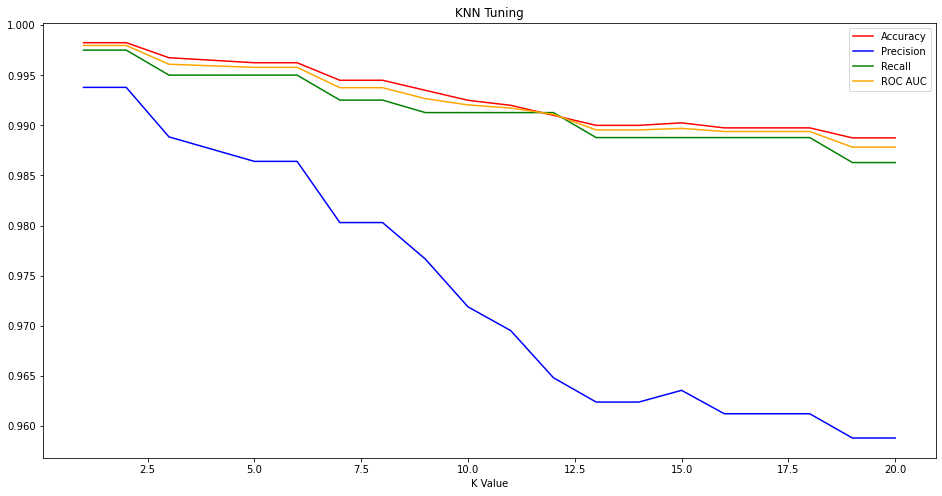

Best K Value: 2 | Best Score: 0.9982495623905977


In [109]:
accuracies = []
precisions = []
recalls = []
ROCs = []

ks = []
best_score = 0
best_k = 0
knn_best_model = None
for x in tqdm(range(1, 21), desc="Evaluating", leave=False):
    ks.append(x)
    t = KNeighborsClassifier(n_neighbors=x, weights='distance').fit(X_train, y_train)
    accuracies.append(t.score(X_test, y_test))
    temp_pred = t.predict(X_test)
    precisions.append(metrics.precision_score(y_test, temp_pred, pos_label=1, average='binary', zero_division=0))
    recalls.append(metrics.recall_score(y_test, temp_pred, pos_label=1, average='binary'))
    ROCs.append(metrics.roc_auc_score(y_test, temp_pred))
    if t.score(X_test, y_test) >= best_score:
        best_score = t.score(X_test, y_test)
        best_k = x
        knn_best_model = t







plt.figure(figsize = (16, 8))
plt.plot(ks, accuracies, label = "Accuracy", color = "red")
plt.plot(ks, precisions, label = "Precision", color = "blue")
plt.plot(ks, recalls, label = "Recall", color = "green")
plt.plot(ks, ROCs, label = "ROC AUC", color = "orange")
plt.legend()
plt.xlabel("K Value")
plt.title("KNN Tuning")
plt.show()

print(f"Best K Value: {best_k} | Best Score: {best_score}")

### Real Data Testing

In [110]:
realknn_ypred = knn_best_model.predict(real_test_X)
print(metrics.classification_report(real_test_Y, realknn_ypred))
print(knn_best_model.score(real_test_X, real_test_Y))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       133
           1       0.00      0.00      0.00        34

    accuracy                           0.80       167
   macro avg       0.40      0.50      0.44       167
weighted avg       0.63      0.80      0.71       167

0.7964071856287425


C:\Users\Sam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [111]:
filename = 'knn_model.sav'
pickle.dump(knn_best_model, open(filename, 'wb'))

## Support Vector Machine

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

linear 1.0
linear 0.1
linear 0.001


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

poly 1.0
poly 0.1
poly 0.001


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

rbf 1.0
rbf 0.1
rbf 0.001


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

sigmoid 1.0
sigmoid 0.1
sigmoid 0.001


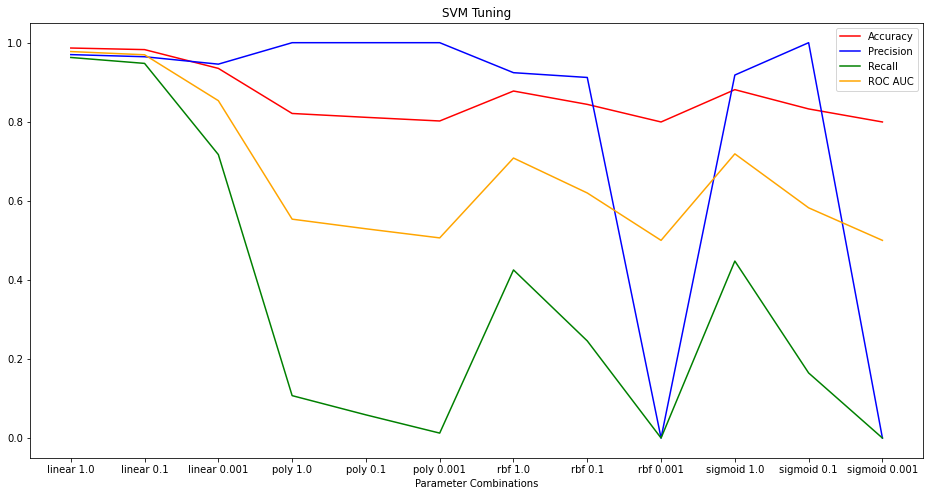

Best Kernel: linear | Best Penalty: 1.0 | Best Score: 0.986496624156039


In [97]:
accuracies = []
precisions = []
recalls = []
ROCs = []
params = []

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
penalties = [1.0, 0.1, 0.001] #[100, 10, 1.0, 0.1, 0.001]

best_score = 0
best_kernel = 'linear'
best_penalty = 100
svm_best_model = None


for k in tqdm(kernels, desc="Evaluating", leave=False):
    for p in tqdm(penalties, desc="Evaluating", leave=False):
        params.append(f"{k} {p}")
        t = svm.SVC(C = p, kernel = k, class_weight='balanced', random_state=0).fit(X_train, y_train)
        accuracies.append(t.score(X_test, y_test))
        temp_pred = t.predict(X_test)
        precisions.append(metrics.precision_score(y_test, temp_pred, pos_label=1, average='binary', zero_division=0))
        recalls.append(metrics.recall_score(y_test, temp_pred, pos_label=1, average='binary'))
        ROCs.append(metrics.roc_auc_score(y_test, temp_pred))
        if t.score(X_test, y_test) > best_score:
            best_score = t.score(X_test, y_test)
            best_kernel = k
            best_penalty = p
            svm_best_model = t
        print(f"{k} {p}")



plt.figure(figsize = (16, 8))
plt.plot(params, accuracies, label = "Accuracy", color = "red")
plt.plot(params, precisions, label = "Precision", color = "blue")
plt.plot(params, recalls, label = "Recall", color = "green")
plt.plot(params, ROCs, label = "ROC AUC", color = "orange")
plt.legend()
plt.xlabel("Parameter Combinations")
plt.title("SVM Tuning")
plt.show()

print(f"Best Kernel: {best_kernel} | Best Penalty: {best_penalty} | Best Score: {best_score}")

### Real Data Testing

In [101]:
realSVC_ypred = svm_best_model.predict(real_test_X)
print(metrics.classification_report(real_test_Y, realSVC_ypred))
print("ROC AUC = " + str(metrics.roc_auc_score(real_test_Y, realSVC_ypred)))
svm_best_model.score(real_test_X, real_test_Y)

              precision    recall  f1-score   support

           0       0.69      0.44      0.54       133
           1       0.10      0.24      0.14        34

    accuracy                           0.40       167
   macro avg       0.40      0.34      0.34       167
weighted avg       0.57      0.40      0.46       167

ROC AUC = 0.33945157010172494


0.40119760479041916

In [102]:
filename = 'svm_model.sav'
pickle.dump(svm_best_model, open(filename, 'wb'))

## Random Forest

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

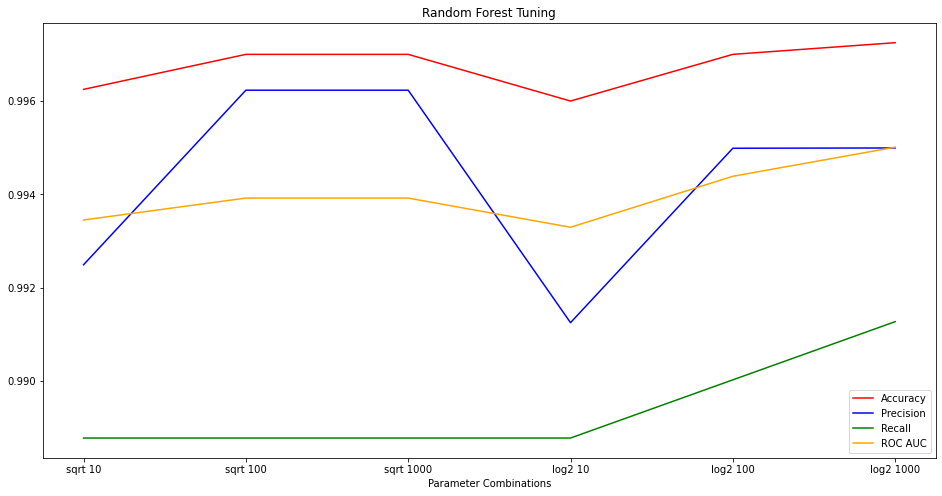

Best n_estimator: 1000 | Best max_features: log2 | Best Score: 0.997249312328082


In [113]:
accuracies = []
precisions = []
recalls = []
ROCAUCs = []
params = []

n_estims = [10, 100, 1000]
max_feats = ['sqrt', 'log2'] #list(range(1,20))

best_score = 0
best_n_estim = 10
best_max_feat = 1
rf_best_model = None

for m in tqdm(max_feats, desc="Evaluating", leave=False):
    for n in tqdm(n_estims, desc="Evaluating", leave=False):
        params.append(f"{m} {n}")
        t = RandomForestClassifier(n_estimators=n, max_depth=None, max_features=m, random_state=0, class_weight="balanced")
        t = t.fit(X_train, y_train)
        accuracies.append(t.score(X_test, y_test))
        temp_pred = t.predict(X_test)
        precisions.append(metrics.precision_score(y_test, temp_pred, pos_label=1, average='binary', zero_division=0))
        recalls.append(metrics.recall_score(y_test, temp_pred, pos_label=1, average='binary'))
        ROCAUCs.append(metrics.roc_auc_score(y_test, temp_pred))
        if t.score(X_test, y_test) > best_score:
            best_score = t.score(X_test, y_test)
            best_n_estim = n
            best_max_feat = m
            rf_best_model = t

        
        
plt.figure(figsize = (16, 8))
plt.plot(params, accuracies, label = "Accuracy", color = "red")
plt.plot(params, precisions, label = "Precision", color = "blue")
plt.plot(params, recalls, label = "Recall", color = "green")
plt.plot(params, ROCAUCs, label = "ROC AUC", color = "orange")
plt.legend()
plt.xlabel("Parameter Combinations")
plt.title("Random Forest Tuning")
plt.show()

print(f"Best n_estimator: {best_n_estim} | Best max_features: {best_max_feat} | Best Score: {best_score}")

### Real Data Testing

In [114]:
realRF_ypred = rf_best_model.predict(real_test_X)
print(metrics.classification_report(real_test_Y, realRF_ypred))
print("ROC AUC = " + str(metrics.roc_auc_score(real_test_Y, realRF_ypred)))
rf_best_model.score(real_test_X, real_test_Y)

              precision    recall  f1-score   support

           0       0.77      0.37      0.50       133
           1       0.18      0.56      0.28        34

    accuracy                           0.41       167
   macro avg       0.48      0.46      0.39       167
weighted avg       0.65      0.41      0.45       167

ROC AUC = 0.46362229102167185


0.40718562874251496

In [115]:
filename = 'rf_model.sav'
pickle.dump(rf_best_model, open(filename, 'wb'))

## Results

In [127]:
mlp_score = 0.7895
log_score = metrics.accuracy_score(real_test_Y, realtestpred)
knn_score = knn_best_model.score(real_test_X, real_test_Y)
svm_score = svm_best_model.score(real_test_X, real_test_Y)
rf_score = rf_best_model.score(real_test_X, real_test_Y)

scores = [mlp_score, log_score, knn_score, svm_score, rf_score]
names = ['MLP', 'Log', 'KNN', 'SVM', 'RF']

print(mlp_score)
print(log_score)
print(knn_score)
print(svm_score)
print(rf_score)

0.7895
0.4311377245508982
0.7964071856287425
0.40119760479041916
0.40718562874251496


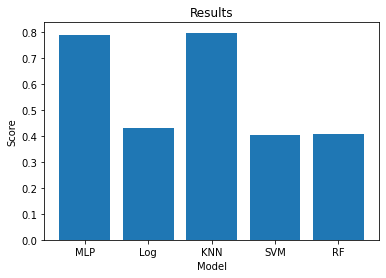

In [128]:
plt.xticks(range(len(scores)), names)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Results')
plt.bar(range(len(scores)), scores) 
plt.show()